# Example-01: Coupled twiss parameters

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=100):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Compute one-turn transport matrix

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, -0.01, -0.25, 0.01], dtype=torch.float64)

m = torch.func.jacfwd(fodo)(x, k)
print(m)

from twiss.twiss import is_stable
print(is_stable(m))

tensor([[ 4.947e-01,  2.032e+01, -8.454e-03,  3.297e-01],
        [-3.725e-02,  4.947e-01,  4.385e-03,  8.052e-03],
        [ 8.052e-03,  3.297e-01, -9.232e-02,  3.539e+00],
        [ 4.385e-03, -8.454e-03, -2.806e-01, -9.232e-02]], dtype=torch.float64)
True


In [6]:
# Compute coupled twiss parameters 

from twiss.twiss import twiss
t, n, w = twiss(m)

print(t)
print(n)
print(w)

tensor([1.677e-01, 2.647e-01], dtype=torch.float64)
tensor([[ 4.835e+00,  0.000e+00,  2.714e-02, -1.890e-17],
        [ 9.205e-18,  2.069e-01,  9.126e-18, -7.283e-03],
        [ 6.634e-02, -1.405e-16,  1.884e+00,  0.000e+00],
        [ 2.380e-17, -2.980e-03,  3.189e-17,  5.308e-01]], dtype=torch.float64)
tensor([[[ 2.338e+01,  4.451e-17,  3.208e-01,  1.151e-16],
         [ 4.451e-17,  4.279e-02, -2.845e-17, -6.165e-04],
         [ 3.208e-01, -2.845e-17,  4.401e-03,  1.998e-18],
         [ 1.151e-16, -6.165e-04,  1.998e-18,  8.881e-06]],

        [[ 7.368e-04,  3.854e-19,  5.115e-02, -9.169e-18],
         [ 3.854e-19,  5.304e-05,  1.720e-17, -3.866e-03],
         [ 5.115e-02,  1.720e-17,  3.550e+00,  6.008e-17],
         [-9.169e-18, -3.866e-03,  6.008e-17,  2.818e-01]]],
       dtype=torch.float64)


In [7]:
# Check normalization matrix

from math import pi
from twiss.matrix import rotation

print(rotation(*2*pi*t))
print(n.inverse() @ m @ n)

tensor([[4.945e-01, 8.692e-01, 0.000e+00, 0.000e+00],
        [-8.692e-01, 4.945e-01, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, -9.220e-02, 9.957e-01],
        [0.000e+00, 0.000e+00, -9.957e-01, -9.220e-02]], dtype=torch.float64)
tensor([[ 4.945e-01,  8.692e-01, -3.806e-17, -1.735e-17],
        [-8.692e-01,  4.945e-01, -1.370e-17,  1.735e-17],
        [-2.126e-17, -2.515e-17, -9.220e-02,  9.957e-01],
        [ 2.803e-18, -3.036e-18, -9.957e-01, -9.220e-02]], dtype=torch.float64)


In [8]:
# Check twiss matrices

from twiss.matrix import symplectic_identity

s = symplectic_identity(len(w), dtype=torch.float64)
u = torch.zeros_like(m)
for ti, wi in zip(t, w):
    u += (wi @ s) * (2*pi*ti).sin() - (wi @ s) @ (wi @ s) * (2*pi*ti).cos()

print(m)
print(u)

tensor([[ 4.947e-01,  2.032e+01, -8.454e-03,  3.297e-01],
        [-3.725e-02,  4.947e-01,  4.385e-03,  8.052e-03],
        [ 8.052e-03,  3.297e-01, -9.232e-02,  3.539e+00],
        [ 4.385e-03, -8.454e-03, -2.806e-01, -9.232e-02]], dtype=torch.float64)
tensor([[ 4.947e-01,  2.032e+01, -8.454e-03,  3.297e-01],
        [-3.725e-02,  4.947e-01,  4.385e-03,  8.052e-03],
        [ 8.052e-03,  3.297e-01, -9.232e-02,  3.539e+00],
        [ 4.385e-03, -8.454e-03, -2.806e-01, -9.232e-02]], dtype=torch.float64)


In [9]:
# Compute twiss at each location

from twiss.twiss import propagate  

out = []
for mapping in (m11, m12, m23, m34, m45, m56, m67, m78, m89):
    w = propagate(w, torch.func.jacfwd(mapping)(x, k))
    out.append(w)
out = torch.stack(out)

print(out.shape)

torch.Size([9, 2, 4, 4])


In [10]:
# Convert to CS and LB represencation 

from twiss.convert import  wolski_to_cs
from twiss.convert import  wolski_to_lb

ax, bx, ay, by = torch.vmap(wolski_to_cs)(out).T
a1x, b1x, a2x, b2x, a1y, b1y, a2y, b2y, *_ = torch.vmap(wolski_to_lb)(out).T

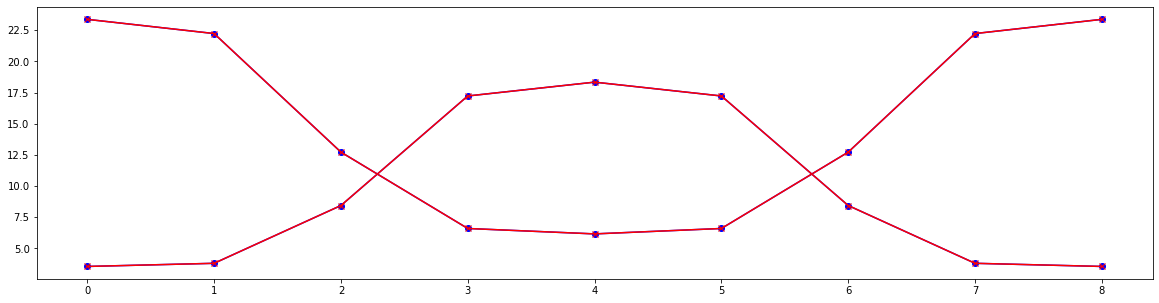

In [11]:
# Plot in-plane twiss parameters

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(9), bx, marker='o', color='blue')
plt.plot(range(9), b1x, marker='x', color='red')
plt.plot(range(9), by, marker='o', color='blue')
plt.plot(range(9), b2y, marker='x', color='red')
plt.show()

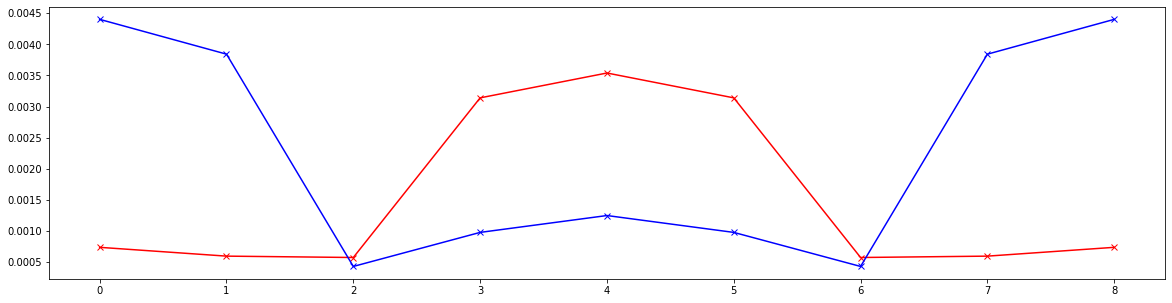

In [12]:
# Plot in-plane coupled twiss parameters

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(9), b2x, marker='x', color='red')
plt.plot(range(9), b1y, marker='x', color='blue')
plt.show()

In [13]:
# Compute phase advances

from twiss.twiss import advance

out = []
for mapping in (m11, m12, m23, m34, m45, m56, m67, m78, m89):
    mu, n = advance(n, torch.func.jacfwd(mapping)(x, k))
    out.append(mu)
out = torch.stack(out)

print(t)
print(1/(2*pi)*out.T.sum(-1))

tensor([1.677e-01, 2.647e-01], dtype=torch.float64)
tensor([1.677e-01, 2.647e-01], dtype=torch.float64)


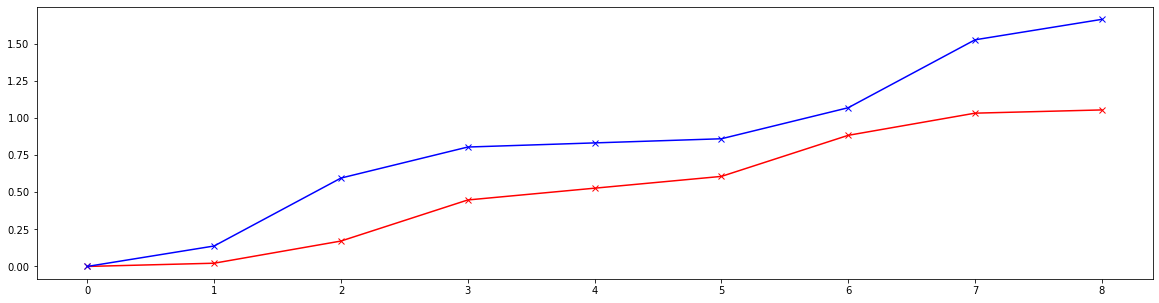

In [14]:
# Plot accumulated phase advance

mux, muy = out.T.cumsum(-1)

plt.figure(figsize=(20, 5))
plt.plot(range(9), mux, marker='x', color='red')
plt.plot(range(9), muy, marker='x', color='blue')
plt.show()

# Example-02: Tune derivatives

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=100):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Compute tune derivatives

from twiss.twiss import twiss

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacfwd(fodo)(x, k)
    t, *_ = twiss(m)
    return t

d1 = torch.func.jacfwd(fn)(k)
d2 = torch.func.jacfwd(torch.func.jacfwd(fn))(k)

print(d1)
print(d2)

tensor([[1.832e+00, 0.000e+00, 5.027e-01, 0.000e+00],
        [-2.895e-01, 0.000e+00, -1.430e+00, 0.000e+00]], dtype=torch.float64)
tensor([[[-1.265e+01, 0.000e+00, -6.635e+00, 0.000e+00],
         [0.000e+00, -1.186e+01, 0.000e+00, -1.682e+01],
         [-6.635e+00, 0.000e+00, -1.070e+00, 0.000e+00],
         [0.000e+00, -1.682e+01, 0.000e+00, -1.547e+01]],

        [[-5.003e-02, 0.000e+00, -2.576e+00, 0.000e+00],
         [0.000e+00, 9.717e+00, 0.000e+00, 8.931e+00],
         [-2.576e+00, 0.000e+00, 7.004e-01, 0.000e+00],
         [0.000e+00, 8.931e+00, 0.000e+00, 1.286e+01]]], dtype=torch.float64)


In [6]:
# Test

dk = torch.tensor([0.005, -0.005, -0.005, 0.005], dtype=torch.float64)

print(fn(k))
print(fn(k) + d1 @ dk)
print(fn(k) + d1 @ dk + 1/2 * d2 @ dk @ dk)
print()

t, *_ = twiss(torch.func.jacfwd(fodo)(x, k + dk))
print(t)
print()

tensor([1.674e-01, 2.645e-01], dtype=torch.float64)
tensor([1.740e-01, 2.702e-01], dtype=torch.float64)
tensor([1.741e-01, 2.703e-01], dtype=torch.float64)

tensor([1.741e-01, 2.703e-01], dtype=torch.float64)



# Example-03: Twiss derivatives

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=100):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Set task function

from twiss.twiss import twiss
from twiss.twiss import propagate
from twiss.convert import wolski_to_cs

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacfwd(fodo)(x, k)
    *_, w = twiss(m)
    out = []
    for mapping in (m11, m12, m23, m34, m45, m56, m67, m78, m89):
        w = propagate(w, torch.func.jacfwd(mapping)(x, k))
        out.append(w)
    out = torch.stack(out)
    ax, bx, ay, by = torch.vmap(wolski_to_cs)(out).T
    return torch.stack([bx, by]).T

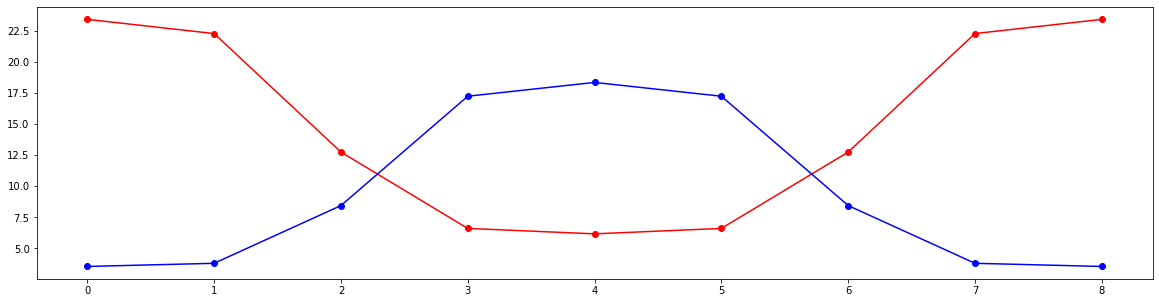

In [6]:
# Compute and plot twiss

bx, by = fn(k).T

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(9), bx, marker='o', color='red')
plt.plot(range(9), by, marker='o', color='blue')
plt.show()

In [7]:
# Compute twiss derivatives

d1 = torch.func.jacfwd(fn)(k)
print(d1.shape)

torch.Size([9, 2, 4])


In [8]:
# Test

dk = torch.tensor([0.005, -0.005, -0.005, 0.005], dtype=torch.float64)

print(fn(k).T)
print((fn(k) + d1 @ dk).T)
print()

print(fn(k + dk).T)
print()

tensor([[2.341e+01, 2.227e+01, 1.274e+01, 6.609e+00, 6.173e+00, 6.609e+00, 1.274e+01, 2.227e+01, 2.341e+01],
        [3.554e+00, 3.806e+00, 8.444e+00, 1.723e+01, 1.834e+01, 1.723e+01, 8.444e+00, 3.806e+00, 3.554e+00]],
       dtype=torch.float64)
tensor([[2.303e+01, 2.188e+01, 1.232e+01, 6.251e+00, 5.828e+00, 6.251e+00, 1.232e+01, 2.188e+01, 2.303e+01],
        [3.395e+00, 3.647e+00, 8.370e+00, 1.741e+01, 1.856e+01, 1.741e+01, 8.370e+00, 3.647e+00, 3.395e+00]],
       dtype=torch.float64)

tensor([[2.305e+01, 2.190e+01, 1.234e+01, 6.262e+00, 5.838e+00, 6.262e+00, 1.234e+01, 2.190e+01, 2.305e+01],
        [3.396e+00, 3.648e+00, 8.373e+00, 1.742e+01, 1.857e+01, 1.742e+01, 8.373e+00, 3.648e+00, 3.396e+00]],
       dtype=torch.float64)



# Example-04: Phase advance derivatives

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=100):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Set task function

from twiss.twiss import twiss
from twiss.twiss import advance

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacfwd(fodo)(x, k)
    _, n, _ = twiss(m)
    out = []
    for mapping in (m12, m23, m34, m45, m56, m67, m78, m89):
        mu, n = advance(n, torch.func.jacfwd(mapping)(x, k))
        out.append(mu)
    return torch.stack(out)

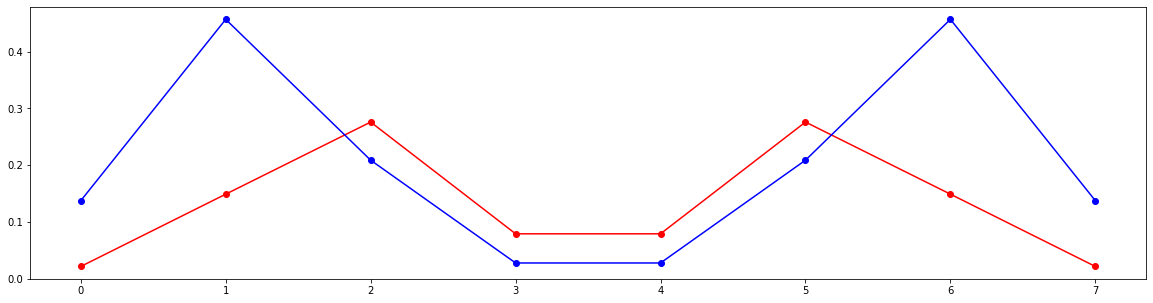

In [6]:
# Compute and plot phase advance

mux, muy = fn(k).T

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(8), mux, marker='o', color='red')
plt.plot(range(8), muy, marker='o', color='blue')
plt.show()

In [7]:
# Compute phase advance derivatives

d1 = torch.func.jacfwd(fn)(k)
print(d1.shape)

torch.Size([8, 2, 4])


In [8]:
# Test

dk = torch.tensor([0.005, -0.005, -0.005, 0.005], dtype=torch.float64)

print(fn(k).T)
print((fn(k) + d1 @ dk).T)
print()

print(fn(k + dk).T)
print()

tensor([[2.172e-02, 1.490e-01, 2.759e-01, 7.918e-02, 7.918e-02, 2.759e-01, 1.490e-01, 2.172e-02],
        [1.375e-01, 4.567e-01, 2.088e-01, 2.784e-02, 2.784e-02, 2.088e-01, 4.567e-01, 1.375e-01]],
       dtype=torch.float64)
tensor([[2.208e-02, 1.527e-01, 2.882e-01, 8.356e-02, 8.356e-02, 2.882e-01, 1.527e-01, 2.208e-02],
        [1.435e-01, 4.691e-01, 2.086e-01, 2.752e-02, 2.752e-02, 2.086e-01, 4.691e-01, 1.435e-01]],
       dtype=torch.float64)

tensor([[2.206e-02, 1.527e-01, 2.884e-01, 8.368e-02, 8.368e-02, 2.884e-01, 1.527e-01, 2.206e-02],
        [1.438e-01, 4.694e-01, 2.085e-01, 2.751e-02, 2.751e-02, 2.085e-01, 4.694e-01, 1.438e-01]],
       dtype=torch.float64)



# Example-05: Tune uncertainty from systematic errors

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=100):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Compute tune derivatives

from twiss.twiss import twiss

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacfwd(fodo)(x, k)
    t, *_ = twiss(m)
    return t

grad = torch.func.jacfwd(fn)(k)

In [6]:
# Compute tune uncertainty for given known knobs uncertanties

sk = torch.tensor([0.01, 0.005, 0.01, 0.005], dtype=torch.float64)

st = (grad**2 @ sk**2).sqrt()
print(st)

st = torch.func.vmap(fn)(k + sk * torch.randn((1024, 4), dtype=torch.float64)).T.std(-1)
print(st)

tensor([1.900e-02, 1.459e-02], dtype=torch.float64)
tensor([1.911e-02, 1.442e-02], dtype=torch.float64)
